In [1]:
import transformers

/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/cg/ynv2m8t90ms2kgkr7xt54kf00000gn/T/ipykernel_11756/3077694403.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = pd.DataFrame({'timestamp': pd.date_range(start='2024-01-01', periods=time_steps, freq='H'),


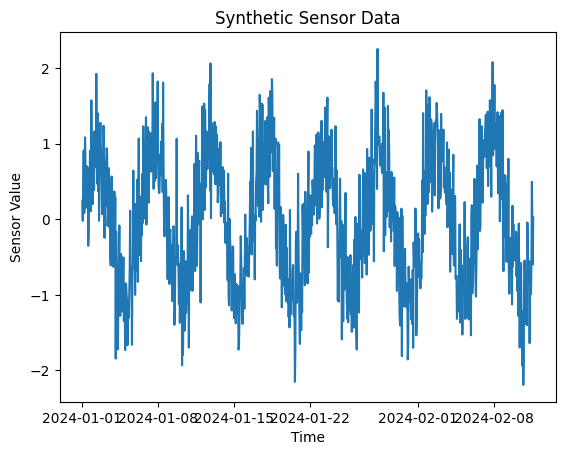

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic sensor data (e.g., temperature readings)
np.random.seed(42)
time_steps = 1000
sensor_data = np.sin(np.linspace(0, 50, time_steps)) + np.random.normal(0, 0.5, time_steps)  # Sine wave with noise

# Create a DataFrame
df = pd.DataFrame({'timestamp': pd.date_range(start='2024-01-01', periods=time_steps, freq='H'),
                   'sensor_value': sensor_data})

# Visualize the sensor data
plt.plot(df['timestamp'], df['sensor_value'])
plt.title('Synthetic Sensor Data')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.show()


In [3]:
from sklearn.preprocessing import MinMaxScaler

# Normalize sensor data
scaler = MinMaxScaler(feature_range=(-1, 1))
df['scaled_value'] = scaler.fit_transform(df['sensor_value'].values.reshape(-1, 1))

# Convert the time-series data into sequences for model training
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

# Create sequences with a window size of 50
window_size = 50
X, y = create_sequences(df['scaled_value'].values, window_size)

# Convert to tensor format suitable for PyTorch models
import torch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [13]:
!pip install sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.8 MB/s eta 0:00:00ta 0:00:01


In [16]:
# Install PyTorch with MPS support
!pip install torch torchvision torchaudio


In [19]:
!pip install transformers  accelerate -U


In [21]:
pip install accelerate

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, DataCollatorWithPadding

# Check if MPS (Metal Performance Shaders) backend is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Generate synthetic sensor data
np.random.seed(42)
time_steps = 1000
sensor_data = np.sin(np.linspace(0, 50, time_steps)) + np.random.normal(0, 0.5, time_steps)

# Preprocessing - Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(sensor_data.reshape(-1, 1)).flatten()

# Create sequences for model training
def create_sequences(data, window_size):
    sequences, targets = [], []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        targets.append(data[i + window_size])
    return np.array(sequences), np.array(targets)

# Prepare sequences with a window size of 50
window_size = 50
X, y = create_sequences(scaled_data, window_size)

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Split into training and validation sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Load tokenizer and model from Hugging Face
model_name = "EleutherAI/gpt-neo-125M"  # Example; ensure the model supports MPS
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set a padding token if not defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Ensure the model config has the pad_token_id set properly
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)
model.config.pad_token_id = tokenizer.pad_token_id

# Define a data collator to handle padding within batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# Prepare DataLoaders
batch_size = 16

# Define a collate function to tokenize input sequences properly
def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    # Convert numerical sequences to strings for tokenization
    X_batch_str = [" ".join(map(str, x)) for x in X_batch]  # Convert each sequence to a string
    # Tokenize the sequences with the padding
    X_batch_tokenized = tokenizer(
        X_batch_str,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    # Move tensors to the correct device
    X_batch_tokenized = {k: v.to(device) for k, v in X_batch_tokenized.items()}
    # Convert labels to tensor
    y_batch_tensor = torch.tensor(y_batch, dtype=torch.float32).to(device)
    return X_batch_tokenized, y_batch_tensor

# Use the collate function with the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
    save_steps=100,
    use_mps_device=torch.backends.mps.is_available()
)

# Custom training loop to include progress bar and validation
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

def train(model, loader):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(**X_batch).logits.squeeze()
        loss = torch.nn.functional.mse_loss(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc="Validating", leave=False):
            outputs = model(**X_batch).logits.squeeze()
            loss = torch.nn.functional.mse_loss(outputs, y_batch)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training loop with validation
for epoch in range(1, training_args.num_train_epochs + 1):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Using device: mps


Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/transformers/training_args.py:2179: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


Epoch 1 - Train Loss: 0.5305, Validation Loss: 0.0962


KeyboardInterrupt: 

In [25]:
import speech_recognition as sr

# Initialize recognizer
recognizer = sr.Recognizer()

# Use the Mac's default microphone as the source
with sr.Microphone() as source:
    print("Adjusting for ambient noise, please wait...")
    recognizer.adjust_for_ambient_noise(source)  # Calibrate for ambient noise
    print("Ready to listen...")

    while True:
        try:
            # Capture the audio from the microphone
            print("Listening...")
            audio = recognizer.listen(source)
            
            # Recognize speech using Google Web Speech API
            print("Recognizing...")
            text = recognizer.recognize_google(audio)
            print(f"Transcription: {text}")

        except sr.UnknownValueError:
            print("Could not understand the audio, please try again.")
        except sr.RequestError as e:
            print(f"Could not request results from the service; {e}")


Adjusting for ambient noise, please wait...
Ready to listen...
Listening...
Recognizing...
Transcription: 1234
Listening...
Recognizing...
Transcription: data science and engineering
Listening...
Recognizing...
Transcription: spark Kafka nifi
Listening...


KeyboardInterrupt: 

In [ ]:
import speech_recognition as sr
import requests

# Initialize recognizer
recognizer = sr.Recognizer()

# Define the URL for the Ollama server
OLLAMA_URL = "http://localhost:11434/api/generate"

# Initialize chat history
chat_history = []

# Function to chat with Llama3.1 via Ollama
def chat_with_llama(text):
    # Add user input to chat history
    chat_history.append(f"User: {text}")
    # Combine chat history into a single string prompt
    full_chat_history = "\n".join(chat_history)

    # Prepare data to send to Ollama
    data = {
        "model": "llama3.1",
        "prompt": full_chat_history,
        "stream": False
    }

    try:
        # Send request to Ollama
        response = requests.post(OLLAMA_URL, json=data)

        if response.status_code == 200:
            # Extract response data
            response_data = response.json().get('response', 'No response from Llama3.1')
            # Append Llama's response to chat history
            chat_history.append(f"Bot: {response_data}")
            return response_data
        else:
            # Handle errors from Ollama
            return f"Error: Failed with status code {response.status_code}. Message: {response.text}"

    except requests.exceptions.RequestException as e:
        return f"Error communicating with Ollama: {e}"

# Use the Mac's default microphone as the source
with sr.Microphone() as source:
    print("Adjusting for ambient noise, please wait...")
    recognizer.adjust_for_ambient_noise(source)  # Calibrate for ambient noise
    print("Ready to listen...")

    while True:
        try:
            # Capture the audio from the microphone
            print("Listening...")
            audio = recognizer.listen(source)
            
            # Recognize speech using Google Web Speech API
            print("Recognizing...")
            text = recognizer.recognize_google(audio)
            print(f"Transcription: {text}")

            # Send recognized text to Llama3.1 and get response
            llama_response = chat_with_llama(text)
            print(llama_response)

        except sr.UnknownValueError:
            print("Could not understand the audio, please try again.")
        except sr.RequestError as e:
            print(f"Could not request results from the service; {e}")


In [4]:
import speech_recognition as sr
import requests
import json

# Initialize recognizer
recognizer = sr.Recognizer()

# Define the URL for the Ollama server
OLLAMA_URL = "http://localhost:11434/api/generate"

# Initialize chat history
chat_history = []

# Function to chat with Llama3.1 via Ollama
def chat_with_llama(text):
    # Add user input to chat history
    chat_history.append(f"User: {text}")
    # Combine chat history into a single string prompt
    full_chat_history = "\n".join(chat_history)

    # Prepare data to send to Ollama
    data = {
        "model": "llama3.1",
        "prompt": full_chat_history,
        "stream": True  # Enable streaming
    }

    try:
        # Send request to Ollama with streaming enabled
        with requests.post(OLLAMA_URL, json=data, stream=True) as response:
            if response.status_code == 200:
                response_text = ""
                buffer = ""  # Buffer to hold streaming parts until a full sentence is formed
                # Read the streaming response line by line
                for line in response.iter_lines():
                    if line:
                        decoded_line = line.decode('utf-8')
                        try:
                            # Parse the JSON response
                            response_data = json.loads(decoded_line)
                            # Extract the 'response' part
                            response_message = response_data.get("response", "")
                            # Append to buffer
                            buffer += response_message
                            
                            # Check if the buffer contains a complete sentence to print
                            if buffer.endswith(('.', '!', '?')):  # Print when ending with a full stop
                                print(f"Bot: {buffer.strip()}")
                                response_text += buffer
                                buffer = ""  # Reset buffer after printing
                            
                        except json.JSONDecodeError:
                            print(f"Error decoding line: {decoded_line}")
                
                # Append any remaining buffer to chat history
                if buffer:
                    print(f"Bot: {buffer.strip()}")
                    response_text += buffer
                
                # Append the full response to chat history after complete reception
                chat_history.append(f"Bot: {response_text.strip()}")
                return response_text.strip()
            else:
                # Handle errors from Ollama
                return f"Error: Failed with status code {response.status_code}. Message: {response.text}"

    except requests.exceptions.RequestException as e:
        return f"Error communicating with Ollama: {e}"

# Use the Mac's default microphone as the source
with sr.Microphone() as source:
    print("Adjusting for ambient noise, please wait...")
    recognizer.adjust_for_ambient_noise(source)  # Calibrate for ambient noise
    print("Ready to listen...")

    while True:
        try:
            # Capture the audio from the microphone
            print("Listening...")
            audio = recognizer.listen(source)
            
            # Recognize speech using Google Web Speech API
            print("Recognizing...")
            text = recognizer.recognize_google(audio)
            print(f"Transcription: {text}")

            # Send recognized text to Llama3.1 and get response
            llama_response = chat_with_llama(text)
            print(llama_response)

        except sr.UnknownValueError:
            print("Could not understand the audio, please try again.")
        except sr.RequestError as e:
            print(f"Could not request results from the service; {e}")


Adjusting for ambient noise, please wait...
Ready to listen...
Listening...
Recognizing...
Transcription: what about the scaling Big Data
Bot: Scaling Big Data involves designing and implementing a system that can handle large amounts of data (big data) efficiently, effectively, and at a low cost.
Bot: Here are some considerations for scaling big data:

**Challenges:**

1.
Bot: **Data Volume**: Handling massive amounts of unstructured and semi-structured data from various sources.
2.
Bot: **Data Velocity**: Processing high-speed streams of data in real-time or near-real-time.
3.
Bot: **Data Variety**: Managing diverse data types, such as text, images, videos, and sensor readings.
4.
Bot: **Data Veracity**: Ensuring data accuracy, quality, and consistency.

**Scaling Strategies:**

1.
Bot: **Horizontal Scaling**: Adding more nodes or servers to a cluster to increase processing power and storage capacity.
2.
Bot: **Vertical Scaling**: Upgrading individual servers with more powerful proce

In [1]:
from flask import Flask, render_template, request, jsonify, stream_with_context, Response
import requests
import json

app = Flask(__name__)

# Define the URL for the Ollama server
OLLAMA_URL = "http://localhost:11434/api/generate"

# Initialize chat history
chat_history = []

# Function to chat with Llama3.1 via Ollama
def chat_with_llama(text):
    # Add user input to chat history
    chat_history.append(f"User: {text}")
    # Combine chat history into a single string prompt
    full_chat_history = "\n".join(chat_history)

    # Prepare data to send to Ollama
    data = {
        "model": "llama3.1",
        "prompt": full_chat_history,
        "stream": True  # Enable streaming
    }

    # Streaming generator function
    def generate():
        try:
            with requests.post(OLLAMA_URL, json=data, stream=True) as response:
                if response.status_code == 200:
                    buffer = ""  # Buffer to hold streaming parts until a full sentence is formed
                    # Read the streaming response line by line
                    for line in response.iter_lines():
                        if line:
                            decoded_line = line.decode('utf-8')
                            try:
                                # Parse the JSON response
                                response_data = json.loads(decoded_line)
                                # Extract the 'response' part
                                response_message = response_data.get("response", "")
                                buffer += response_message
                                
                                # Print and yield a complete sentence
                                if buffer.endswith(('.', '!', '?')):
                                    yield f"data: {buffer.strip()}\n\n"
                                    chat_history.append(f"Bot: {buffer.strip()}")
                                    buffer = ""
                            except json.JSONDecodeError:
                                print(f"Error decoding line: {decoded_line}")
                    
                    # Yield any remaining buffer as final response
                    if buffer:
                        yield f"data: {buffer.strip()}\n\n"
                        chat_history.append(f"Bot: {buffer.strip()}")
                else:
                    yield f"data: Error: Failed with status code {response.status_code}. Message: {response.text}\n\n"
        except requests.exceptions.RequestException as e:
            yield f"data: Error communicating with Ollama: {e}\n\n"

    return generate()

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/chat', methods=['POST'])
def chat():
    user_input = request.form['user_input']
    # Stream response to the client
    return Response(stream_with_context(chat_with_llama(user_input)), mimetype='text/event-stream')

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5002, debug=True)  # Changing the port and allowing external access



 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5002
 * Running on http://192.168.2.41:5002
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/opt/anaconda3/envs/trans0/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/trans0/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 692, in init

SystemExit: 1

/opt/anaconda3/envs/trans0/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
